In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
sns.set_palette("deep")
print("📌 Numerical EDA Template Loaded")


📌 Numerical EDA Template Loaded


In [2]:
df = pd.read_csv(r"C:\Users\WELCOME\Desktop\MLPROJECTS\notebook\data\stud.csv")
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (1000, 8)


,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [3]:
cat_cols = df.select_dtypes(include=["object", "category"]).columns
print("Categorical Features:", list(cat_cols))


Categorical Features: ['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course']


In [4]:
cat_info = pd.DataFrame({
    "unique_values": [df[c].nunique() for c in cat_cols],
    "missing_percent": (df[cat_cols].isna().mean()*100).round(2)
}, index=cat_cols)

cat_info.sort_values("unique_values", ascending=False)


,unique_values,missing_percent
parental_level_of_education,6,0.0
race_ethnicity,5,0.0
gender,2,0.0
lunch,2,0.0
test_preparation_course,2,0.0


Interpretation:
high cardinality → encoding risk
missing patterns → leakage / bias risk

In [5]:
# Frequency Distribution + Rare Category Detection
THRESHOLD = 0.02  # 2%

for col in cat_cols:
    print(f"\n📌 Feature: {col}")
    freq = (df[col].value_counts(normalize=True)*100).round(2)

    display(freq)

    rare = freq[freq < THRESHOLD*100]
    if len(rare) > 0:
        print("⚠️ Rare Categories (<2% frequency):")
        display(rare)



📌 Feature: gender


gender
female    51.8
male      48.2
Name: proportion, dtype: float64


📌 Feature: race_ethnicity


race_ethnicity
group C    31.9
group D    26.2
group B    19.0
group E    14.0
group A     8.9
Name: proportion, dtype: float64


📌 Feature: parental_level_of_education


parental_level_of_education
some college          22.6
associate's degree    22.2
high school           19.6
some high school      17.9
bachelor's degree     11.8
master's degree        5.9
Name: proportion, dtype: float64


📌 Feature: lunch


lunch
standard        64.5
free/reduced    35.5
Name: proportion, dtype: float64


📌 Feature: test_preparation_course


test_preparation_course
none         64.2
completed    35.8
Name: proportion, dtype: float64

Rare classes → noise after encoding,
Consider grouping into "OTHER".

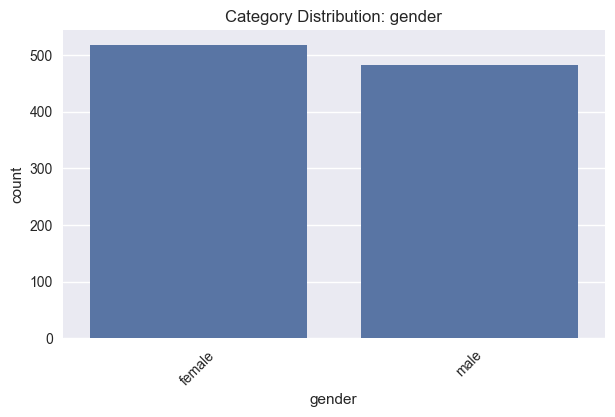

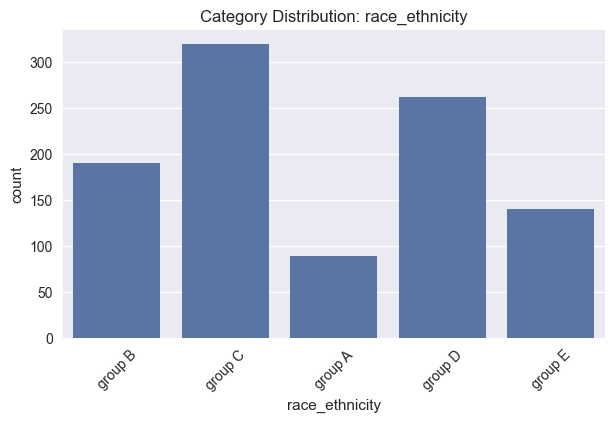

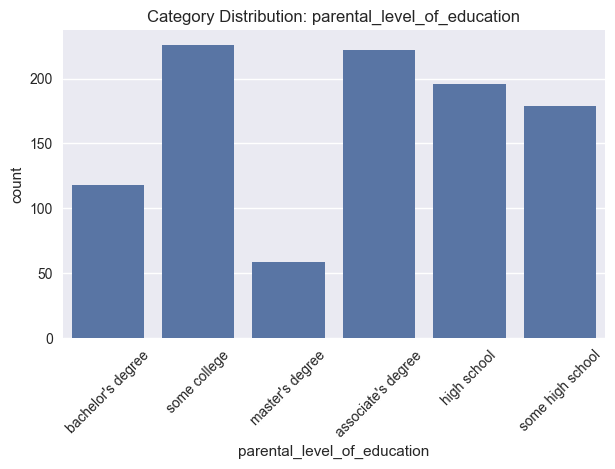

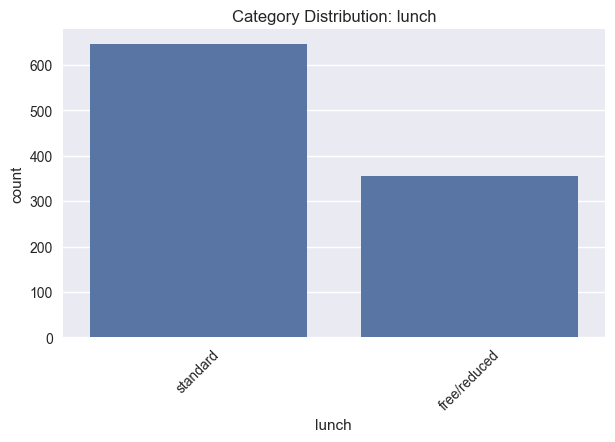

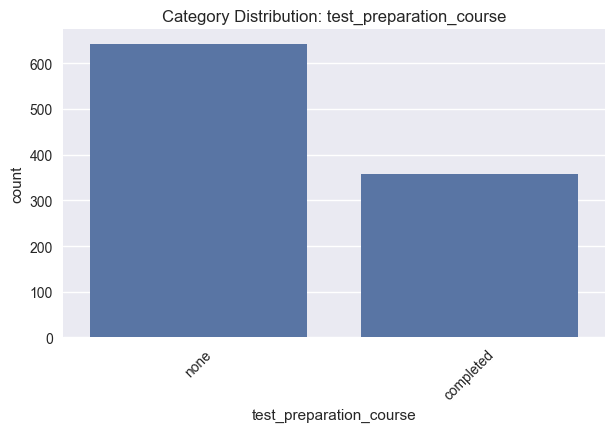

In [6]:
# Countplot — Category Distribution
for col in cat_cols:
    plt.figure(figsize=(7,4))
    sns.countplot(x=df[col])
    plt.title(f"Category Distribution: {col}")
    plt.xticks(rotation=45)
    plt.show()


Look for:
dominant categories,
unbalanced distributions,
garbage labels (?, -, blanks)

In [7]:
df['total_score'] = df['math_score'] + df['reading_score'] + df['writing_score']
df['average'] = df['total_score']/3
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,total_score,average
0,female,group B,bachelor's degree,standard,none,72,72,74,218,72.666667
1,female,group C,some college,standard,completed,69,90,88,247,82.333333
2,female,group B,master's degree,standard,none,90,95,93,278,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,148,49.333333
4,male,group C,some college,standard,none,76,78,75,229,76.333333


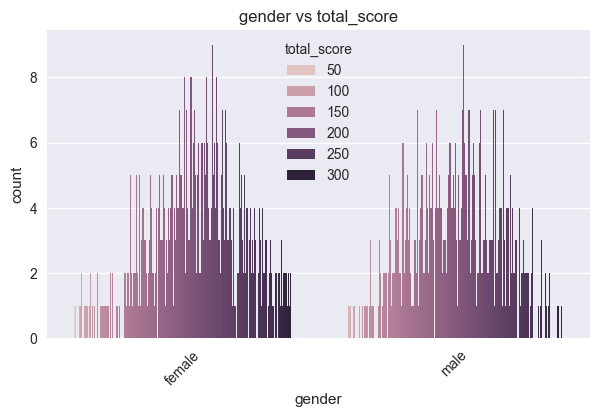

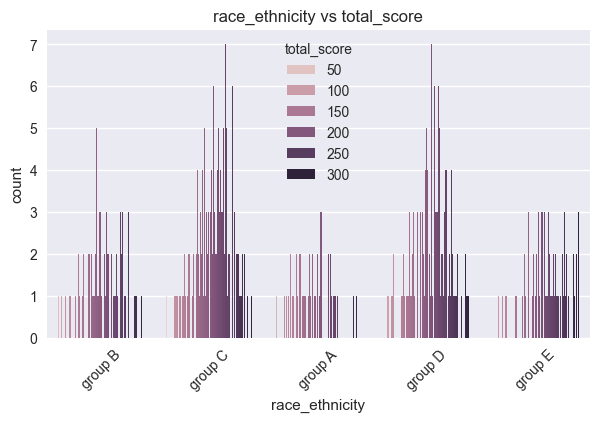

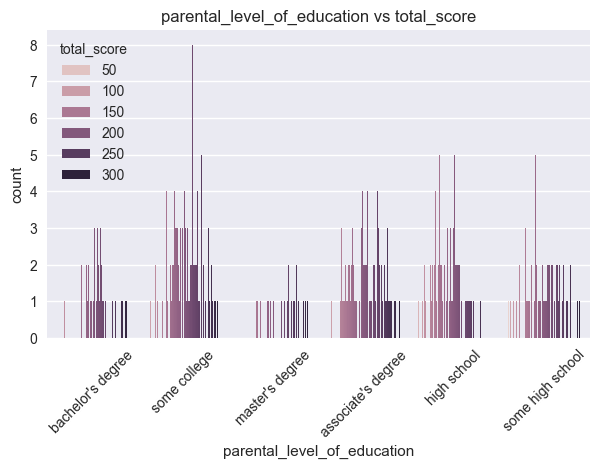

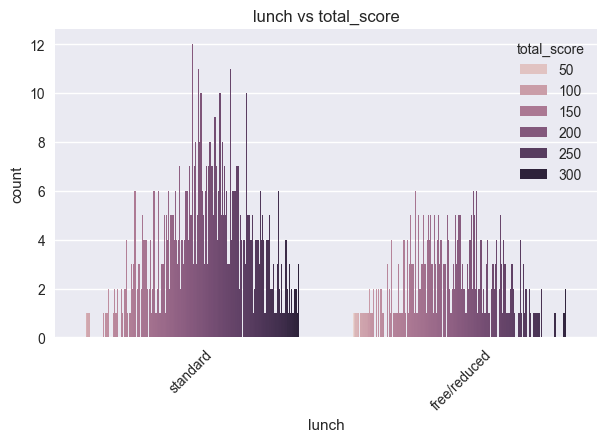

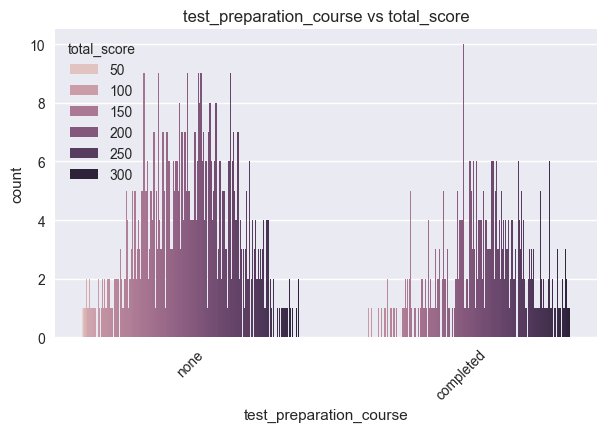

In [8]:
target = "total_score"
# Classification — Category vs Target Distribution
for col in cat_cols:
    if col != target:
        plt.figure(figsize=(7,4))
        sns.countplot(x=df[col], hue=df[target])
        plt.title(f"{col} vs {target}")
        plt.xticks(rotation=45)
        plt.show()


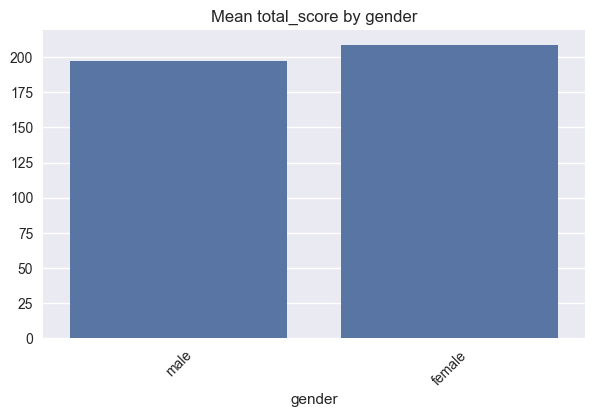

gender
male      197.512448
female    208.708494
Name: total_score, dtype: float64

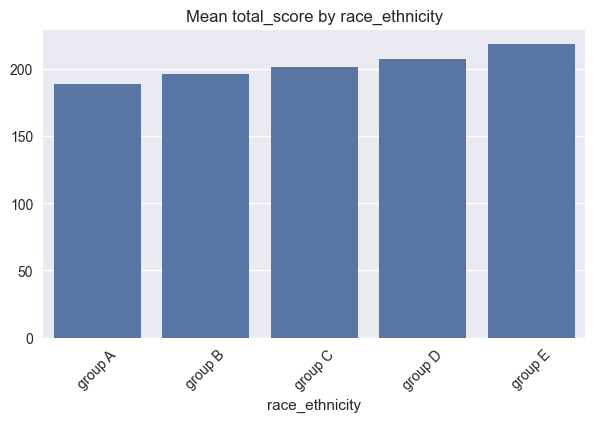

race_ethnicity
group A    188.977528
group B    196.405263
group C    201.394984
group D    207.538168
group E    218.257143
Name: total_score, dtype: float64

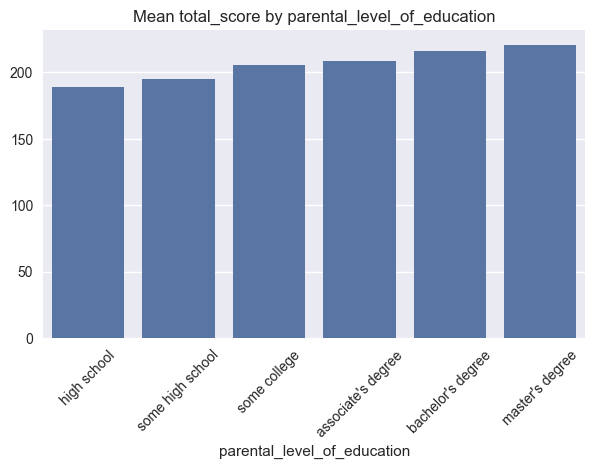

parental_level_of_education
high school           189.290816
some high school      195.324022
some college          205.429204
associate's degree    208.707207
bachelor's degree     215.771186
master's degree       220.796610
Name: total_score, dtype: float64

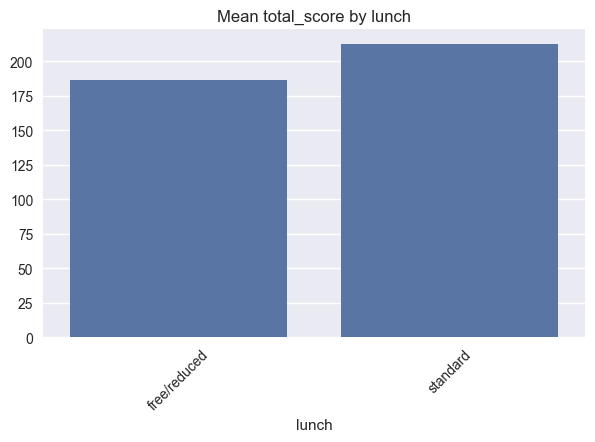

lunch
free/reduced    186.597183
standard        212.511628
Name: total_score, dtype: float64

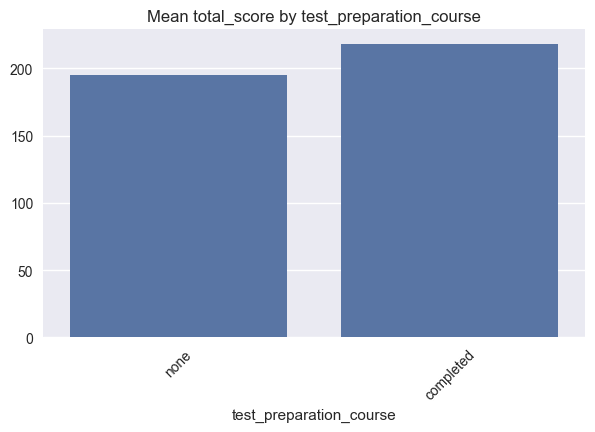

test_preparation_course
none         195.116822
completed    218.008380
Name: total_score, dtype: float64

In [9]:
# Regression — Mean Target per Category
for col in cat_cols:
    if col != target:
        group_means = df.groupby(col)[target].mean().sort_values()
        plt.figure(figsize=(7,4))
        sns.barplot(x=group_means.index, y=group_means.values)
        plt.title(f"Mean {target} by {col}")
        plt.xticks(rotation=45)
        plt.show()

        display(group_means)


High variance between groups → strong feature,
Flat bar pattern → weak feature

In [10]:
# Category Stability Check (Across Samples)
for col in cat_cols:
    support = (df[col].value_counts(normalize=True)*100).round(2)
    low_support = support[support < 1]

    if len(low_support) > 0:
        print(f"\n⚠️ Low Support Categories (<1%) in {col}:")
        display(low_support)


These may:
overfit after encoding
cause sparse dummy columns

In [11]:
# Encoding Suitability Suggestion Helper
encoding_suggestion = []

for col in cat_cols:
    n = df[col].nunique()

    if n <= 10:
        enc = "One-Hot Encoding ✓"
    elif n <= 30:
        enc = "Frequency / Target Encoding ⚠"
    else:
        enc = "High Cardinality — Avoid One-Hot ❌ Use Target / Hash Encoding"

    encoding_suggestion.append((col, n, enc))

pd.DataFrame(encoding_suggestion,
             columns=["Feature", "Unique Categories", "Recommended Encoding"])


,Feature,Unique Categories,Recommended Encoding
0,gender,2,One-Hot Encoding ✓
1,race_ethnicity,5,One-Hot Encoding ✓
2,parental_level_of_education,6,One-Hot Encoding ✓
3,lunch,2,One-Hot Encoding ✓
4,test_preparation_course,2,One-Hot Encoding ✓


What This Template Helps You Detect

It identifies:

✔ rare categories
✔ unstable categories
✔ dominant categories
✔ class-wise separation power
✔ biased or leaking categories
✔ encoding risks
✔ high-cardinality features
✔ useless ID-like fields